# 0. Set up

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from itertools import chain
import pickle
from pickle_utils import pickle_load, pickle_dump
from loadGlove import loadGloveModel

In [233]:
captions = pd.read_csv("captions.csv", error_bad_lines=False, warn_bad_lines=False)
print("Skipping bad lines - return to this later")
print(captions.shape)
captions.sample(10, random_state=22)

Skipping bad lines - return to this later
(155392, 3)


,image,above_text,below_text
54053,My Precious Gollum,Hello TARA...,HELLO PRECIOUS
67160,Ecstatic Michael Phelps,tHERE'S A POT OF THE STUFF?,i LOVE POT.
49626,katt williams shocked,What,you actually thought you were getting rp?
9727,Okay Guy,TOOK AN ARROW TO THE KNEE,OKAY..
22047,Rich Men Laughing,and then we told them,their health insurance premiums wouldnt go up
150193,kim jong un,they see me rulin',they hatin'
121915,The Olympic Queen,vodka,NaN
132328,Paperclip,it looks like you're having trouble,fapping to this meme
120444,Honey BooBoo,happy birthday,ali boo boo
15655,Not sure if troll,not sure if nicki minaj,or a mutant from mortal combat


# 1. Load GloVe and save objects for later use

In [6]:
glove_objs = loadGloveModel("glove.txt")

In [8]:
glove_index_dict = glove_objs[0]
glove_embedding_weights = glove_objs[1]

In [9]:
len(glove_index_dict), glove_embedding_weights.shape

(1917494, (1917494, 300))

In [7]:
# pickle_dump(glove_objs, "glove_objs.pkl")
# glove_objs = pickle_load("glove_objs.pkl")

writing total_bytes=4632882170...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 3221225472)... done.
writing bytes [3221225472, 4294967296)... done.
writing bytes [4294967296, 4632882170)... done.


# 2. Clean captions and labels

## a. Remove where there are NaNs in the captions or labels

In [234]:
np.sum(pd.isna(captions))

image           13
above_text    6137
below_text    7199
dtype: int64

In [235]:
captions.iloc[np.where(pd.isna(captions.image))]

,image,above_text,below_text
18546,NaN,several people get up and leave as they can se...,NaN
43899,NaN,teacher is even later than you,NaN
57525,NaN,Ekki málið :),NaN
100719,NaN,Ert þú starfsmaður þarna eða eigandi?,NaN
100723,NaN,uppiskorpi!!!,NaN
100725,NaN,Eða bara eldisfiskur. LOL.,NaN
100728,NaN,Takk kærlega fyrir þetta :),NaN
105241,NaN,makes us strong,NaN
105243,NaN,makes us strong,NaN
114690,NaN,Nei þá nærðu í rauðvín,NaN


In [236]:
captions = captions[pd.notnull(captions.image)]
captions = captions.replace(np.nan, '', regex=True)

In [237]:
np.sum(pd.isna(captions))

image         0
above_text    0
below_text    0
dtype: int64

## b. Everything to lower

In [238]:
captions['image'] = captions['image'].str.lower()
captions['above_text'] = captions['above_text'].str.lower()
captions['below_text'] = captions['below_text'].str.lower()

In [239]:
captions.sample(10, random_state=33)

,image,above_text,below_text
148743,bender popular,todos se iban a paro,la usm solo quería ser popular
60086,uncle dolan pls,clovhy pls,
81607,lawn chair blown over,cerberus earthquake 2012,we will rebuild
79323,pizzeria los hijos de puta,y monsters university?,para cuando monsters university?!
42541,liberal douche garofalo,overregulates everything into complete disfunc...,"defends it as ""the new normal"""
6074,joker mind loss,a girl kiss a girl in public and no one bats a...,a boy kiss a boy in public and everyone loses ...
152361,over obsessive girlfriend,why,is sleep more important than me kim?
142516,tony horton,recovery week,it's a beautiful thing!
42871,mens wearhouse,you're gonna like how the site looks,i guarantee it
7923,butthurt dweller,talk shit on internet,feel superior


## c. Remove rows with non-English words

### d. Remove other bad rows

Combine `above_text` and `below_text` here with appropriate breakpoint tokens. Will re-use this later to tokenize.

In [240]:
breakpoint_captions = "<sos> " + captions.above_text + " <break> " + captions.below_text + " <eos>"

In [241]:
# limit to caption length to under some reasonable upper bound for a meme caption
# for many, the scrape just got messed up and appended many captions into one observation
longinds = []
toolong = 50
howmany = 0
for i, cap in enumerate(breakpoint_captions):
    splitcap = cap.split()
    if len(splitcap) > toolong:
        longinds.append(i)
        howmany += 1
captions = captions.drop(captions.index[longinds])
breakpoint_captions = breakpoint_captions.drop(breakpoint_captions.index[longinds])
print("Deleted {} rows".format(howmany))

Deleted 139 rows


# 3. Create word mappings

Structure borrowed from Harvard IACS 2019 ComputeFest [code](https://github.com/Harvard-IACS/2019-computefest/blob/master/Friday/data_preprocess.ipnb.ipynb).

### a. Vocabulary

In [242]:
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

In [243]:
vocab, vocabcount = get_vocab(list(captions.image) + list(captions.above_text) + list(captions.below_text))


### b. word2idx and idx2word mappings

Add padding!!!!!!!!!!!

In [244]:
sos = 0
eos = 1  
br = 2
start_idx = br+1 

def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<sos>'] = empty
    word2idx['<eos>'] = eos
    word2idx['<break>'] = br
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [245]:
word2idx, idx2word = get_idx(vocab, vocabcount)

### c. Form embedding matrix

For the words in our observed data, grab the GloVe embeddings. If the word didn't exist in GloVe, initialize it with uniform weights. 

**Maybe I should be deleting rows where no GloVe embeddings exist?**

In [246]:
vocab_size = len(word2idx) # ??
embedding_dim = 300
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w))
    if g is None and w.startswith('#'):
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1

### d. Create mapping dictionaries and final data arrays

In [247]:
# this is all specific to dataset used for ComputeFest
# maybe change it up 
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In ComputeFest code, they find nearest neighbors and make substitutions. I'm doing that for now but may come back to it. What I might try to do is only make substitutions for Meme Generator words that did not have GloVe embeddings and **only if** those words have a neighbor within a certain distance (or maybe this condition isn't necessary).

In [248]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]
nb_unknown_words = 100
glove_thr = 0.5

glove_match = []
for w,idx in word2idx.items():    
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:        
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of GloVe substitutes found', len(glove_match))

# of GloVe substitutes found 17


In [249]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

This next cell creates what should be the data we need.

In [250]:
tokenized_captions = [[word2idx[token] for token in cap.split()] for cap in breakpoint_captions]

Sanity check.

In [251]:
print(captions.above_text[24] + " " + captions.below_text[24])
print(breakpoint_captions[24])
print(tokenized_captions[24])
for token in tokenized_captions[24]:
    print(idx2word[token])

teammates y u no revive me?
<sos> teammates <break> y u no revive me? <eos>
[0, 6959, 2, 68, 64, 19, 11013, 550, 1]
<sos>
teammates
<break>
y
u
no
revive
me?
<eos>


### e. Validate findings

Length: 50, index: 55693 
 <sos>                                                                                                                                                                i think you know me well enough watson to understand that i am by no means a nervous man.  at the same time it is stupidity rather than courage to refuse to recognize danger when it is close upon you.                                                                                                                                                                                             -arthur conan doyle the final problem 1893									     <break>   <eos>


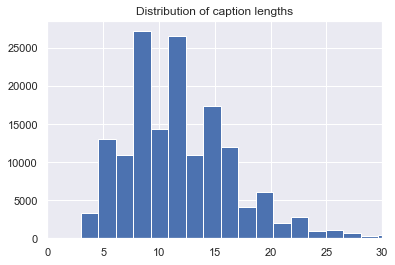

In [255]:
maxlen = 0
longcap = ""
ind = 0
lens = []
for i, cap in enumerate(breakpoint_captions):
    splitcap = cap.split()
    lens.append(len(splitcap))
    if len(splitcap) > maxlen:
        maxlen = len(splitcap)
        longcap = cap
        ind = i
print("Length: {}, index: {} \n {}".format(maxlen, ind, longcap))
plt.hist(lens, bins=30)
plt.xlim([0, 30])
plt.title("Distribution of caption lengths");

### f. Save

In [ ]:
# with open(os.path.join(pickle_path,FN),'wb') as f:
#     pickle.dump((embedding, idx2word, word2idx, glove_idx2idx), fp, pickle.HIGHEST_PTROTOCOL)

---